# Korrelation & Zusammenhangsanalyse

In diesem Notebook analysieren wir die Zusammenhänge zwischen verschiedenen Variablen im Taxi-Datensatz. Wir untersuchen:
- Korrelationen zwischen numerischen Variablen
- Zusammenhänge zwischen Fahrtstrecke, Dauer und Kosten
- Zeitliche Muster und deren Einfluss auf andere Variablen

## 1. Daten laden und vorbereiten

In [29]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import random
import csv
import os

# Einstellungen für bessere Visualisierung
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Größere Plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [30]:
# Bereinigten Datensatz aus Notebook 3 laden
df_clean = pd.read_csv('../data/Taxi_final_1M_clean.csv')

# Zeitvariablen berechnen
df_clean['pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['pickup_hour'] = df_clean['pickup_datetime'].dt.hour
df_clean['pickup_day_of_week'] = df_clean['pickup_datetime'].dt.dayofweek

print(f"Bereinigter Datensatz geladen: {df_clean.shape[0]:,} Zeilen, {df_clean.shape[1]} Spalten")
print(f"Fehlende Werte: {df_clean.isnull().sum().sum()}")
print("\nErste Zeilen:")
df_clean.head()


Bereinigter Datensatz geladen: 931,406 Zeilen, 20 Spalten
Fehlende Werte: 0

Erste Zeilen:


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,pickup_datetime,pickup_hour,pickup_day_of_week
0,2023-02-06 18:31:28,2023-02-06 18:41:28,1.0,2.8,162,113,1,11.4,2.5,2.00,0.0,1.0,19.90,2.5,0.0,10.0,27.4,2023-02-06 18:31:28,18,0
1,2023-01-24 12:53:51,2023-01-24 13:06:09,5.0,2.3,142,48,2,12.1,0.0,0.00,0.0,1.0,16.10,2.5,0.0,12.3,18.1,2023-01-24 12:53:51,12,1
2,2023-02-04 22:58:49,2023-02-04 23:03:11,2.0,1.1,107,107,1,5.8,3.5,1.20,0.0,1.0,12.00,2.5,0.0,4.4,24.9,2023-02-04 22:58:49,22,5
3,2023-02-02 16:39:15,2023-02-02 16:50:39,1.0,2.9,234,249,1,12.1,2.5,3.72,0.0,1.0,22.32,2.5,0.0,11.4,24.9,2023-02-02 16:39:15,16,3
4,2023-02-15 21:08:32,2023-02-15 21:14:12,1.0,1.2,230,48,1,7.2,1.0,2.44,0.0,1.0,14.64,2.5,0.0,5.7,21.1,2023-02-15 21:08:32,21,2


## 2. Korrelationsmatrix - Überblick über alle Zusammenhänge

Wir berechnen die Korrelation zwischen allen numerischen Variablen. Der Korrelationskoeffizient misst die Beziehung zwischen zwei Variablen und liegt zwischen -1 und +1:
- +1: Perfekte positive Korrelation
- 0: Keine lineare Korrelation
- -1: Perfekte negative Korrelation

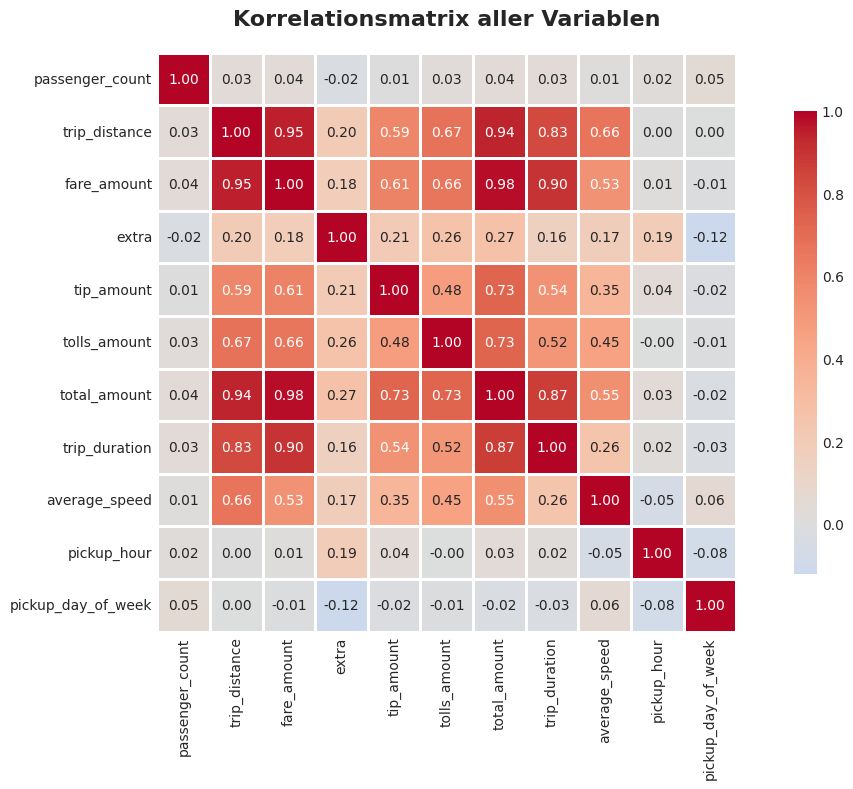

In [31]:
# Auswahl der numerischen Variablen
numerical_cols = ['passenger_count', 'trip_distance', 'fare_amount', 
                  'extra', 'tip_amount', 'tolls_amount', 
                  'total_amount', 'trip_duration', 'average_speed',
                  'pickup_hour', 'pickup_day_of_week']

# Korrelationsmatrix
correlation_matrix = df_clean[numerical_cols].corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Korrelationsmatrix aller Variablen', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [32]:
# Die stärksten Korrelationen identifizieren (Diagonale auslassen)
# Korrelationsmatrix zu DataFrame 
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # Diagonale entfernen

# Sortieren nach 
strong_correlations = corr_pairs.abs().sort_values(ascending=False).drop_duplicates()

print("Die stärksten Korrelationen:")
for idx, value in strong_correlations.head(15).items():
    print(f"{idx[0]:15s} <-> {idx[1]:15s}: {corr_pairs[idx]:7.3f}")

Die stärksten Korrelationen:
fare_amount     <-> total_amount   :   0.978
fare_amount     <-> trip_distance  :   0.952
total_amount    <-> trip_distance  :   0.940
fare_amount     <-> trip_duration  :   0.897
trip_duration   <-> total_amount   :   0.869
trip_duration   <-> trip_distance  :   0.834
tip_amount      <-> total_amount   :   0.730
tolls_amount    <-> total_amount   :   0.728
tolls_amount    <-> trip_distance  :   0.672
trip_distance   <-> average_speed  :   0.663
tolls_amount    <-> fare_amount    :   0.658
fare_amount     <-> tip_amount     :   0.608
tip_amount      <-> trip_distance  :   0.587
total_amount    <-> average_speed  :   0.546
trip_duration   <-> tip_amount     :   0.538


## 3. Detaillierte Analyse: Fahrstrecke und Fahrpreis

Eine der wichtigsten Zusammenhänge ist die Beziehung zwischen der Fahrstrecke (`trip_distance`) und dem Fahrpreis (`fare_amount`). Das soll fast 1:1 korrelieren.

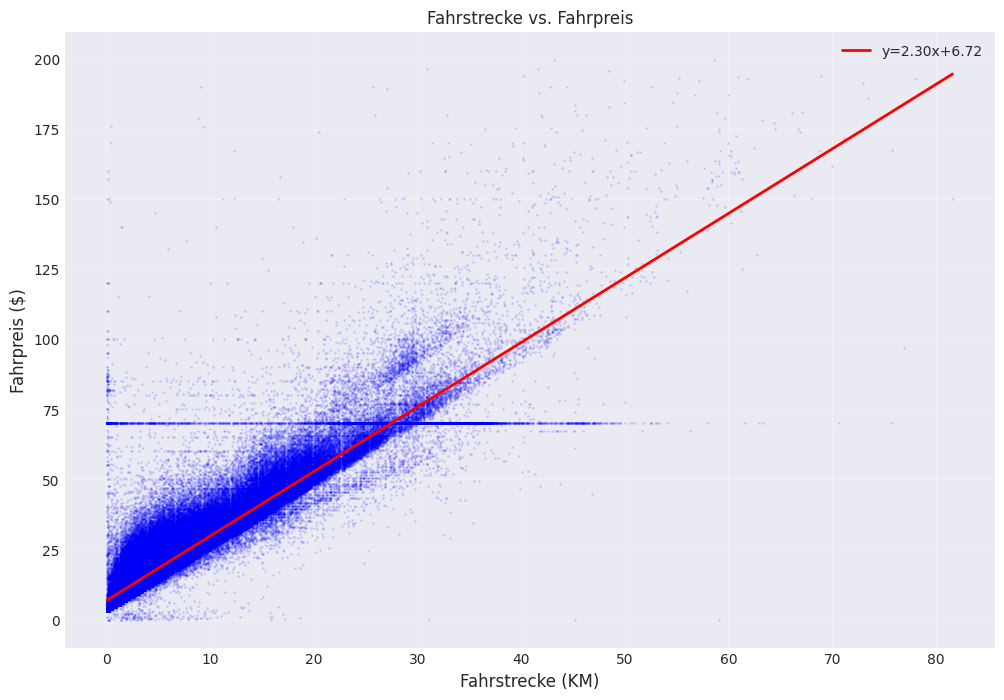

In [33]:
# Scatterplot: Fahrstrecke vs. Fahrpreis
plt.scatter(df_clean['trip_distance'], df_clean['fare_amount'], 
                alpha=0.1, s=1, c='blue')

# Regressionslinie hinzufügen
z = np.polyfit(df_clean['trip_distance'], df_clean['fare_amount'], 1)
p = np.poly1d(z)
plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')

plt.xlabel('Fahrstrecke (KM)', fontsize=12)
plt.ylabel('Fahrpreis ($)', fontsize=12)
plt.title('Fahrstrecke vs. Fahrpreis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


Noch sind viele Ausreisser und wahrscheinliche Datenfehler zu sehen. Aber es gibt eine deutliche korrelation (und logischerweise Kausalität) zwischen Fahrpreis und Fahrtstrecke


## 4. Zusammenhang: Fahrstrecke und Fahrdauer

Untersuchen wir nun die Beziehung zwischen Fahrstrecke und Fahrdauer. Diese sollte auch positiv korrelieren, wobei die Durchschnittsgeschwindigkeit auch wichtig ist.

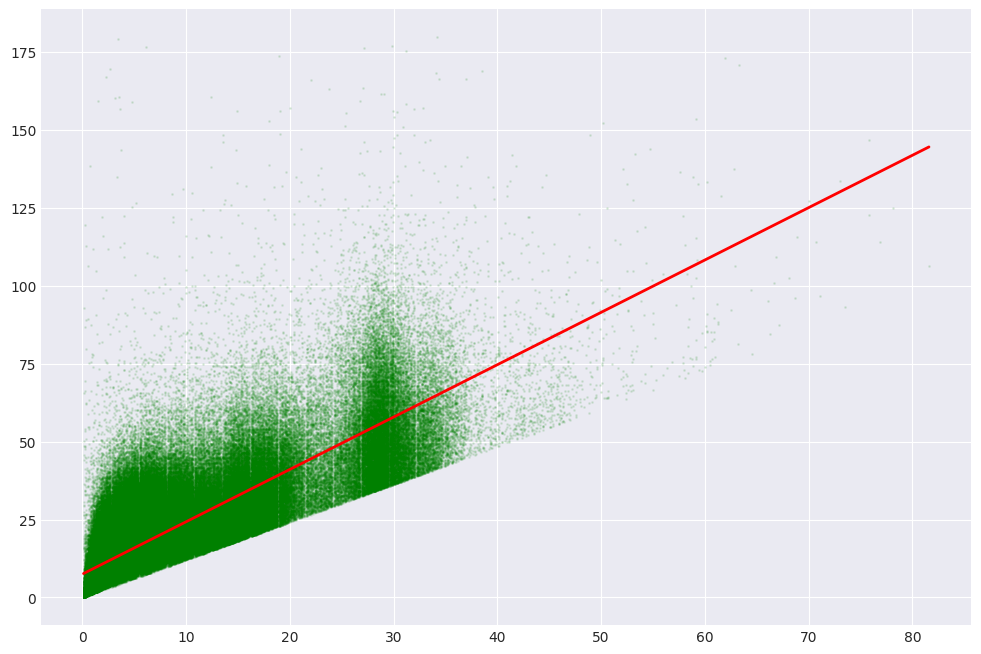


Durchschnittliche Geschwindigkeit aller Fahrten: 28.08 km/h


In [34]:
# Scatterplot: Fahrstrecke vs. Fahrdauer
plt.scatter(df_clean['trip_distance'], df_clean['trip_duration'], 
                alpha=0.1, s=1, c='green')

z = np.polyfit(df_clean['trip_distance'], df_clean['trip_duration'], 1)
p = np.poly1d(z)

plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2)
plt.show()

# Durchschnittliche Geschwindigkeit
avg_speed_overall = df_clean['average_speed'].mean()
print(f"\nDurchschnittliche Geschwindigkeit aller Fahrten: {avg_speed_overall:.2f} km/h")


## 5. Zusammenhang: Trinkgeld und Fahrpreis

Ein interessanter Zusammenhang ist die Beziehung zwischen dem Trinkgeld (`tip_amount`) und dem Fahrpreis (`fare_amount`). Wir erwarten ein höheres Trinkgeld bei höheren Fahrpreis, da es konvention ist prozentual Trinkgeld zu geben

/tmp/ipykernel_1991/1229661017.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


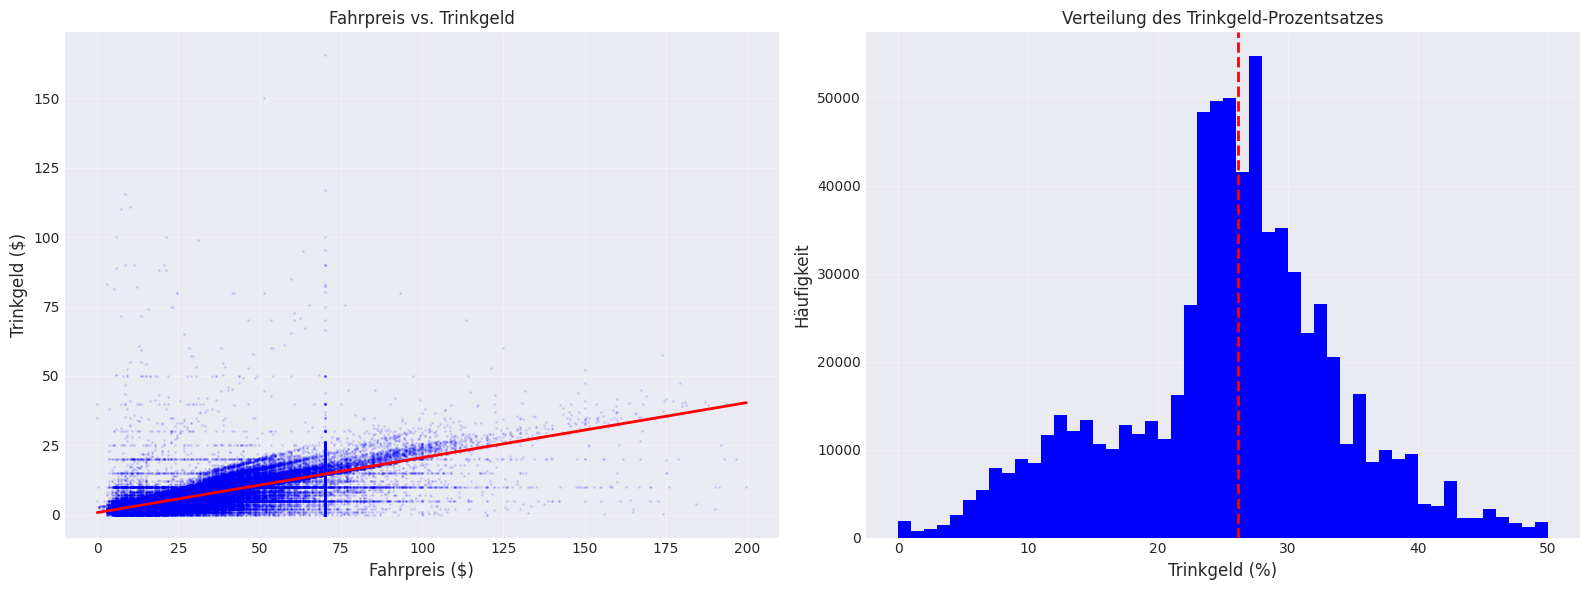

---Trinkgeld Statistiken---
Durchschnittlicher Prozentsatz Trinkgeld: 27.17%
Median Prozentsatz Trinkgeld: 26.13%
Fahrten mit Trinkgeld: 729,603 (78.3%)
Fahrten ohne Trinkgeld: 201,803 (21.7%)


In [35]:
# Trinkgeld-Prozentsatz berechnen
df_clean['tip_percentage'] = (df_clean['tip_amount'] / df_clean['fare_amount']) * 100

# Nur Fahrten mit Trinkgeld 
df_with_tip = df_clean[df_clean['tip_amount'] > 0].copy()
median_tip_perfentage = df_with_tip["tip_percentage"].median()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatterplot: Fahrpreis vs. Trinkgeld
axes[0].scatter(df_with_tip['fare_amount'], df_with_tip['tip_amount'], 
              alpha=0.1, s=1, color='blue')

z = np.polyfit(df_with_tip['fare_amount'], df_with_tip['tip_amount'], 1) # Schätzung Regressionsgrade
p = np.poly1d(z) # Polynom von z um zu plotten

axes[0].plot(df_with_tip['fare_amount'].sort_values(), 
          p(df_with_tip['fare_amount'].sort_values()), 
                "r-", linewidth=2)

axes[0].set_xlabel('Fahrpreis ($)', fontsize=12)
axes[0].set_ylabel('Trinkgeld ($)', fontsize=12)
axes[0].set_title('Fahrpreis vs. Trinkgeld')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Trinkgeld-Prozentsatz Verteilung Histrogramm
df_with_tip[df_with_tip['tip_percentage'] <= 50]['tip_percentage'].hist(
    bins=50, ax=axes[1], color='blue')

axes[1].set_xlabel('Trinkgeld (%)', fontsize=12)
axes[1].set_ylabel('Häufigkeit', fontsize=12)
axes[1].set_title('Verteilung des Trinkgeld-Prozentsatzes')
axes[1].axvline(median_tip_perfentage, color='red', 
              linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("---Trinkgeld Statistiken---")
print(f"Durchschnittlicher Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].mean():.2f}%")
print(f"Median Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].median():.2f}%")
print(f"Fahrten mit Trinkgeld: {len(df_with_tip):,} ({len(df_with_tip)/len(df_clean)*100:.1f}%)")
print(f"Fahrten ohne Trinkgeld: {len(df_clean) - len(df_with_tip):,} ({(len(df_clean) - len(df_with_tip))/len(df_clean)*100:.1f}%)")

## TODO / Weitere Ideen
- Passagierzahl Zusammenhang mit verschiedenen Variablen
- Häufigsten Routen / Orte (Map zu LocationID's)
- Zahlungsmethode vs. Tip percentage
- Tageszeit vs. Tip/Distance/etc.